In [4]:
from cyberbattle.simulation import model as model
from cyberbattle.simulation import actions
from cyberbattle.simulation.model import NodeID, NodeInfo, VulnerabilityID, VulnerabilityInfo
from typing import Dict, Iterator, cast, Tuple

import networkx as nx
import matplotlib as plt
import itertools

In [5]:
class SimpleNode:
    def __init__(self, name, allowed_credentials, connected_nodes, leaked_credentials):
        """ 
        allowed_credentials is a list of strings representing the credentials that can be used to connect to the node
        connected_nodes is a list of node names (strings) that the node has out-going connections to
        leaked_credentials is a list of model.CachedCredential with all of the credentials that are revealed by a local attack on the node
        """
        self.name = name
        self.allowed_credentials = allowed_credentials
        self.connected_nodes = connected_nodes
        self.leaked_credentials = leaked_credentials

def create_network(simple_nodes):
    """ simple_nodes is a list of SimpleNodes """
    nodes = {}
    
    default_allow_rules = [ model.FirewallRule("SSH", model.RulePermission.ALLOW) ]
    
    # Create and add model.NodeInfo objects to nodes
    for simple_node in simple_nodes:
        node_info = model.NodeInfo(
            services=[
                model.ListeningService("SSH", allowedCredentials=simple_node.allowed_credentials),
            ],
            firewall=model.FirewallConfiguration(incoming=default_allow_rules, outgoing=default_allow_rules),
            vulnerabilities=dict(
                ScanForConnectedMachines=model.VulnerabilityInfo(
                    description="Search network for connected machines",
                    type=model.VulnerabilityType.LOCAL,
                    outcome=model.LeakedNodesId(simple_node.connected_nodes),
                    reward_string="Revealed nodes connected to machine",
                    cost=1.0
                ),
                ScanForCredential=model.VulnerabilityInfo(
                    description="Scan for credentials",
                    type=model.VulnerabilityType.LOCAL,
                    outcome=model.LeakedCredentials(credentials=simple_node.leaked_credentials),
                    reward_string=f"Revealed ssh credentials {simple_node.leaked_credentials}",
                    cost=1.0
                ),
            ))
        nodes[simple_node.name] = node_info
    # Create network graph
    network = nx.DiGraph()
    network.add_nodes_from([(k, {'data': v}) for (k, v) in list(nodes.items())])
    # add edges between connecting nodes
    for simple_node in simple_nodes:
        for connected_node in simple_node.connected_nodes:
            network.add_edge(simple_node.name, connected_node, kind=actions.EdgeAnnotation.REMOTE_EXPLOIT)
    return nodes, network

In [6]:
client_node = SimpleNode( name="client",
                allowed_credentials =[], 
                connected_nodes =["1", "2", "4"], 
                leaked_credentials = [
                    model.CachedCredential(node="1", port="SSH", credential="0")
                ]
               )
simple_node_1 = SimpleNode( name="1",
                allowed_credentials =["0"], 
                connected_nodes =["3"], 
                leaked_credentials = [
                    model.CachedCredential(node="2", port="SSH", credential="1"),
                ]
               )
simple_node_2 = SimpleNode( name="2",
                allowed_credentials =["1"], 
                connected_nodes =[], 
                leaked_credentials = [
                    model.CachedCredential(node="4", port="SSH", credential="2"),
                    model.CachedCredential(node="3", port="SSH", credential="2"),
                    model.CachedCredential(node="5", port="SSH", credential="2"),
                ]
               )
simple_node_3 = SimpleNode( name="3",
                allowed_credentials =["2"], 
                connected_nodes =["5"], 
                leaked_credentials = []
               )
simple_node_4 = SimpleNode( name="4",
                allowed_credentials =["2"], 
                connected_nodes =[], 
                leaked_credentials = []
               )

simple_node_5 = SimpleNode( name="5",
                allowed_credentials =["2"], 
                connected_nodes =[], 
                leaked_credentials = []
               )
nodes_list = [client_node, simple_node_1, simple_node_2, simple_node_3, simple_node_4, simple_node_5]
nodes, network = create_network(nodes_list)
print(network.nodes)
print(network.edges)

['client', '1', '2', '3', '4', '5']
[('client', '1'), ('client', '2'), ('client', '4'), ('1', '3'), ('3', '5')]


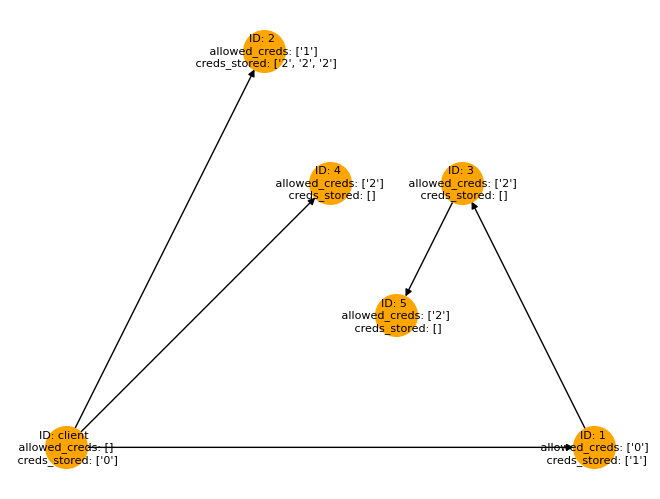

In [7]:
node_labels = {}
for node in nodes_list:
    node_labels[node.name] = f"ID: {node.name} \n allowed_creds: {[credential for credential in node.allowed_credentials]} \n creds_stored: {[credential.credential for credential in node.leaked_credentials]}"

pos = nx.planar_layout(network)
nx.draw(network, pos=pos, with_labels=True, node_color="orange", node_size=900, labels=node_labels, font_size=8)

['client', '1', '2', '4', '3', '5']
{'allowed_creds': [], 'connected_nodes': ['1', '2', '4'], 'creds_stored': [CachedCredential(node='1', port='SSH', credential='0')]}


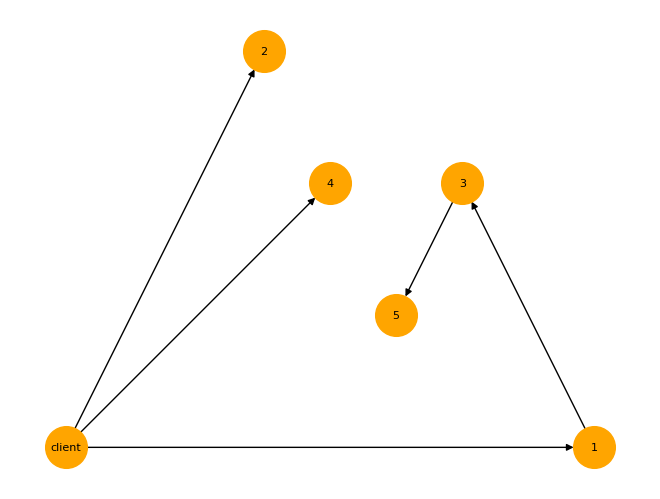

In [38]:
from networkx.readwrite import json_graph
import json

client_node = SimpleNode( name="client",
                allowed_credentials =[], 
                connected_nodes =["1", "2", "4"], 
                leaked_credentials = [
                    model.CachedCredential(node="1", port="SSH", credential="0")
                ]
               )
simple_node_1 = SimpleNode( name="1",
                allowed_credentials =["0"], 
                connected_nodes =["3"], 
                leaked_credentials = [
                    model.CachedCredential(node="2", port="SSH", credential="1"),
                ]
               )
simple_node_2 = SimpleNode( name="2",
                allowed_credentials =["1"], 
                connected_nodes =[], 
                leaked_credentials = [
                    model.CachedCredential(node="4", port="SSH", credential="2"),
                    model.CachedCredential(node="3", port="SSH", credential="2"),
                    model.CachedCredential(node="5", port="SSH", credential="2"),
                ]
               )
simple_node_3 = SimpleNode( name="3",
                allowed_credentials =["2"], 
                connected_nodes =["5"], 
                leaked_credentials = []
               )
simple_node_4 = SimpleNode( name="4",
                allowed_credentials =["2"], 
                connected_nodes =[], 
                leaked_credentials = []
               )

simple_node_5 = SimpleNode( name="5",
                allowed_credentials =["2"], 
                connected_nodes =[], 
                leaked_credentials = []
               )
nodes_list = [client_node, simple_node_1, simple_node_2, simple_node_3, simple_node_4, simple_node_5]

def create_seralizable_network(simple_nodes):
    """ 
    Creates a network that can be seralized by json_graph.adjacency_data, the normal cbs networks use NodeInfo objects in the graphs and 
    they are not seralizable.
    """
    network = nx.DiGraph()
    for simple_node in simple_nodes:
        network.add_node(simple_node.name, allowed_creds=simple_node.allowed_credentials, connected_nodes=simple_node.connected_nodes, creds_stored=simple_node.leaked_credentials)
        for connected_node in simple_node.connected_nodes:
            network.add_edge(simple_node.name, connected_node)
    return network

network = create_seralizable_network(nodes_list)
data = json_graph.adjacency_data(network)
with open('network.json', 'w') as f:
    json.dump(data, f)
    
print(network.nodes)
print(network.nodes["client"])

pos = nx.planar_layout(network)
nx.draw(network, pos=pos, with_labels=True, node_color="orange", node_size=900, font_size=8)

In [15]:
class State:
    def __init__(self, name, attacker_pos, obtained_credentials, firewall_state, turn):
        """ 
        name: id of the state
        attacker_pos: location of the attacker in the network, value is the id of a network node
        obtained_credentials: boolean array of length # of credentials, True/False depending on whether the attacker has that credential
        firewall_state: boolean array of length # of edges in the network, True/False for whether that edge can be used (incoming connections allowed)
        """
        self.name = name
        self.turn = turn
        self.attacker_pos = attacker_pos
        self.obtained_credentials = obtained_credentials
        self.firewall_state = firewall_state
        
    def __str__(self):
        return f"Name: {self.name}\n\t Attacker Position: {self.attacker_pos}\n\t Obtained Credentials: {self.obtained_credentials}\n\t Firewall State: {self.firewall_state}\n\t Turn: {self.turn}\n"

def construct_states(simple_nodes):
    states = [] # list of state objects that can be used to construct game graph
    edges = [] # list of edges between states
    
    unique_credentials = set()
    connections = []
    network_nodes = []
    for node in simple_nodes:
        network_nodes.append(node.name)
        connections.extend([(node.name, target_node) for target_node in node.connected_nodes])
        unique_credentials.update(node.allowed_credentials) # add credentials that can be used to connect to the node
        for leaked_credential in node.leaked_credentials:
            unique_credentials.update(leaked_credential.credential) # add credentials that are stored on the node
    
    possible_firewall_states = list(itertools.product([0, 1], repeat=len(connections)))
    possible_obtained_credentials_states = list(itertools.product([0, 1], repeat=len(unique_credentials)))
    
    state_number = 0
    for i in network_nodes:
        for firewall_state in possible_firewall_states:
            for obtained_credentials in possible_obtained_credentials_states:
                states.append(State(state_number, i, obtained_credentials, firewall_state, 1))
                state_number += 1
                states.append(State(state_number, i, obtained_credentials, firewall_state, 2))
    return states
    
def construct_edges(simple_nodes, states, initial_state):
    # 0 no_action
    # 1 change_host(i, j)
    # 2 local_attack(host)
    # 3 gain_ownership(host)
    # 4 firewall_change(fire_wall_settings)
    pass

states = construct_states(nodes_list)
for i in range(5):
    print(states[i])
print(len(states))
# print(edges[4])
# print(states[0], states[36])
# print(len(edges))


Name: 0
	 Attacker Position: client
	 Obtained Credentials: (0, 0, 0)
	 Firewall State: (0, 0, 0, 0, 0)
	 Turn: 1

Name: 1
	 Attacker Position: client
	 Obtained Credentials: (0, 0, 0)
	 Firewall State: (0, 0, 0, 0, 0)
	 Turn: 2

Name: 1
	 Attacker Position: client
	 Obtained Credentials: (0, 0, 1)
	 Firewall State: (0, 0, 0, 0, 0)
	 Turn: 1

Name: 2
	 Attacker Position: client
	 Obtained Credentials: (0, 0, 1)
	 Firewall State: (0, 0, 0, 0, 0)
	 Turn: 2

Name: 2
	 Attacker Position: client
	 Obtained Credentials: (0, 1, 0)
	 Firewall State: (0, 0, 0, 0, 0)
	 Turn: 1

3072
